In [1]:
# Copyright 2018 The Sonnet Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================


# Borrowed from https://github.com/deepmind/sonnet and ported it to PyTorch

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import gc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
#import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import librosa, librosa.display

from vq_vae_2 import Model

from tqdm.notebook import tqdm

In [4]:
seed = 0
epochs = 600
batch_size = 64
learning_rate = 2e-5

num_hiddens = 128 #128
num_residual_hiddens = 32
num_residual_layers = 4
embedding_dim = 64 #64 : 코드북에서 한 ebedding의 크기
num_embeddings = 256 #512 : embbeding vector 개수 -> indices의 최대 크기
commitment_cost = 0.25

print_every = 100

# data_variance, data_mean, data_std = 298.7436551399305, -42.99114339002469, 17.284202473354984

In [5]:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
#device = torch.device('cpu')

In [7]:
device

device(type='cuda')

In [8]:
num_split = 100
class MelData(Dataset):
    def __init__(self, file_path):
        self.data = []
        genre = ['classical', 'rock', 'electronic', 'pop', 'deam']
        print("Load data...")
        for g in genre:
            print(f'{g}:')
            for i in tqdm(range(1, 2059)):
                for j in range(num_split):
                    tmp_path = f'{file_path}/{g}/{i}-{j}.csv'
                    try:
                        mel = pd.read_csv(tmp_path).iloc[:, :512]
                        if mel.shape == (80, 512):
                            self.data.append((mel, g, i, j))
                    except FileNotFoundError:
                        continue
            print()
                    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        mel, g, i, j = self.data[idx]
        mel = torch.from_numpy(pd.get_dummies(mel).values)
        mel = mel.type(torch.cuda.FloatTensor)
        
        return (g, i, j), mel

class EmotionalData(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        tmp_data = self.data.iloc[idx]
        genre, idx = tmp_data[0].split('_')
        emo = tmp_data[1:]
        return idx, genre, torch.FloatTensor(emo)

In [9]:
EMO_PATH = "./mean_data.csv"
MEL_ARR_PATH = "./split_mel_array"
SAVE_PATH = "./save_models"

In [10]:
mel_arr_data = MelData(MEL_ARR_PATH)
emo_data = EmotionalData(EMO_PATH)

Load data...
classical:


  0%|          | 0/2058 [00:00<?, ?it/s]


rock:


  0%|          | 0/2058 [00:00<?, ?it/s]


electronic:


  0%|          | 0/2058 [00:00<?, ?it/s]


pop:


  0%|          | 0/2058 [00:00<?, ?it/s]


deam:


  0%|          | 0/2058 [00:00<?, ?it/s]

In [11]:
mel_arr_data_loader = DataLoader(
        dataset=mel_arr_data, batch_size=batch_size, shuffle=True)

emo_data_loader = DataLoader(
        dataset=emo_data, batch_size=batch_size, shuffle=True)

In [12]:
def compute_var(data):
    mean, vsum = 0, 0
    length = 0
    data = data
    for d in tqdm(data):
        tmp = np.array(d[0]).flatten() / (3.8147e-06 + 80)
        for val in tmp:
            mean += val.sum()
        length += len(tmp)
    mean /= length
    print(f"mean: {mean}")
    for d in tqdm(data):
        tmp = np.array(d[0]).flatten() / (3.8147e-06 + 80)
        for val in tmp:
            vsum += (val - mean)**2
    variance = vsum / length
    print(f"variance: {variance}")
    return variance

In [13]:
#data_variance = compute_var(mel_arr_data.data)

In [14]:
# data_variance = np.var(np.array([x[0] for x in mel_arr_data.data]) / 80)
data_variance = 0.04615571692705267

In [15]:
model = Model().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_recon_err = []
train_perplexity = []

gc.collect()

37

In [16]:
import importlib
import vq_vae_2_half_tmb
importlib.reload(vq_vae_2_half_tmb)
from vq_vae_2_half_tmb import Model

model = Model().to(device)

In [17]:
# test model

# display(model)
with torch.no_grad():
    test_x = torch.rand(1, 1, 80, 512).to(device)
    _, _, _, ids = model.encode(test_x)
    print(test_x.size())
    print(model(test_x)[1].size())
    print([i.shape for i in ids])
    print([(torch.min(i).item(), torch.max(i).item()) for i in ids])

torch.Size([1, 1, 80, 512])
torch.Size([1, 1, 80, 512])
[torch.Size([1, 10, 16]), torch.Size([1, 20, 32]), torch.Size([1, 40, 64])]
[(337, 337), (115, 443), (132, 396)]


In [18]:
model = Model(num_hiddens=num_hiddens, 
                  num_residual_layers=num_residual_layers,
                  num_residual_hiddens=num_residual_hiddens,
                  num_embeddings=num_embeddings,
                  embedding_dim=embedding_dim, 
                  commitment_cost=commitment_cost).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_recon_err = []
train_perplexity = []

gc.collect()

0

In [19]:
def scaled(x):
    return (x + 80.0) / (3.8147e-06 + 80)
def unscaled(x):
    return x * (3.8147e-06 + 80) - 80.0

In [20]:
for epoch in tqdm(range(epochs)):
    for iteration, (_, x) in enumerate(mel_arr_data_loader):
        # emo data
        #_, _, c = next(iter(emo_data_loader))
        
        x = scaled(x)
        x = x.unsqueeze(1)
        x = x.to(device)
        
        optimizer.zero_grad()

        vq_loss, x_recon, perplexity = model(x)
        recon_error = F.mse_loss(x_recon, x) / data_variance
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
        
    if (epoch) % 100 == 0:
        print(f"epochs:\t{epoch}")
        print(f"loss:\t{loss.item(): .3f}")
        print(f"recon_error:\t{np.mean(train_recon_err[-len(mel_arr_data_loader)+1:]): .3f}")
        print(f"perplexity:\t{np.mean(train_perplexity[-len(mel_arr_data_loader)+1:]): .3f}")
        print(f"vq_loss:\t{vq_loss.item(): .3f}")

        with torch.no_grad():
            _, x = mel_arr_data[0]
            x = scaled(x)
            x.to(device)
            _, x_recon, _ = model(x.view(1, 1, 80, 512))
            
            x = x.detach().cpu().numpy()
            fig = plt.figure(figsize=(15, 9))
            plt.subplot(211)
            librosa.display.specshow(unscaled(x), sr=22050, hop_length=256)
            
            x_recon = x_recon.squeeze().detach().cpu().numpy()
            plt.subplot(212)
            librosa.display.specshow(unscaled(x_recon), sr=22050, hop_length=256)

            fig.savefig(f"outputs/vqvae2/{epoch}.png")
            plt.close()

        print()
    train_recon_err.append(recon_error.item())
    train_perplexity.append(perplexity.item())

  0%|          | 0/600 [00:00<?, ?it/s]

epochs:	0
loss:	 2.867
recon_error:	 nan
perplexity:	 nan
vq_loss:	 0.750


/home/gibeom/.conda/envs/audio/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gibeom/.conda/envs/audio/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



epochs:	100
loss:	 0.145
recon_error:	 0.129
perplexity:	 46.350
vq_loss:	 0.121

epochs:	200
loss:	 0.137
recon_error:	 0.073
perplexity:	 84.838
vq_loss:	 0.124

epochs:	300
loss:	 0.133
recon_error:	 0.024
perplexity:	 131.998
vq_loss:	 0.120

epochs:	400
loss:	 0.161
recon_error:	 0.013
perplexity:	 202.438
vq_loss:	 0.151



KeyboardInterrupt: 

Text(0.5, 0, 'iteration')

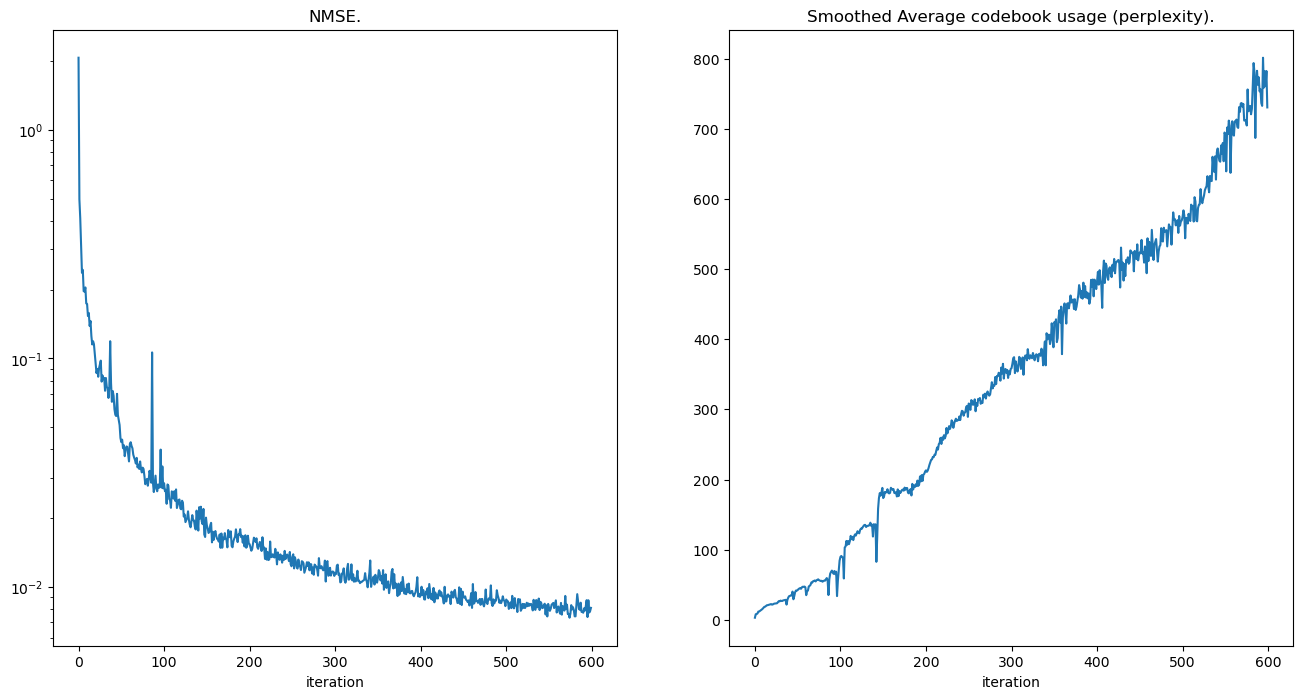

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_err)
ax.set_yscale('log')
ax.set_title('NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)

ax.plot(train_perplexity)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [21]:
# 79.84939575195312
min_err = min(train_recon_err)
# torch.save(model, f'{SAVE_PATH}/vqvae2-{min_err:.5f}.pt')
torch.save(model.state_dict(), f'{SAVE_PATH}/vqvae2_tmb-{min_err:.5f}_dict.pt')
print(min_err)

0.008331568911671638


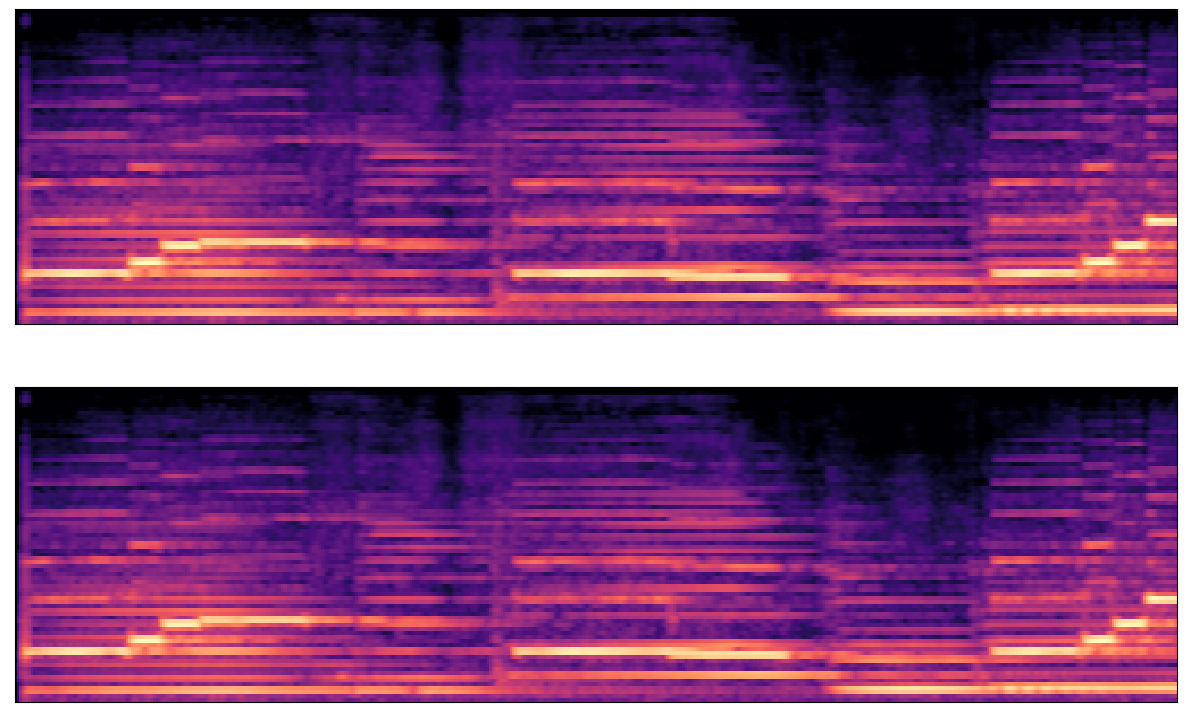

In [ ]:
import soundfile
with torch.no_grad():
    # torch.Size([32, 5, 64, 4]) 32, 5, 64, 128
    # torch.Size([10240, 1024])
    _, x = mel_arr_data[0]
    out = librosa.db_to_power((x).detach().cpu().numpy(), ref=80)
    y = librosa.feature.inverse.mel_to_audio(out, sr=22050, n_fft=2048, hop_length=256)
    soundfile.write("sample/origin_audio.wav", y, 22050, format='WAV')
    x = scaled(x)
    x.to(device)
    _, x_recon, _ = model(x.unsqueeze(0).unsqueeze(0))
    
    x = x.detach().cpu().numpy()
    fig = plt.figure(figsize=(15, 9))
    plt.subplot(211)
    librosa.display.specshow(unscaled(x), sr=22050, hop_length=256)
    
    x_recon = x_recon.squeeze().detach().cpu().numpy()
    plt.subplot(212)
    librosa.display.specshow(unscaled(x), sr=22050, hop_length=256)
    
    out = librosa.db_to_power(unscaled(x), ref=80)
    y = librosa.feature.inverse.mel_to_audio(out, sr=22050, n_fft=2048, hop_length=256)
    soundfile.write("sample/recon_audio.wav", y, 22050, format='WAV')

In [ ]:
model = Model(num_hiddens=num_hiddens, 
                  num_residual_layers=num_residual_layers,
                  num_residual_hiddens=num_residual_hiddens,
                  num_embeddings=num_embeddings,
                  embedding_dim=embedding_dim, 
                  commitment_cost=commitment_cost).to(device)
score = 0.0063145775347948074
PATH = f'{SAVE_PATH}/vqvae2_light-{score:.5f}_dict.pt'
model.load_state_dict(torch.load(PATH))

FileNotFoundError: [Errno 2] No such file or directory: './save_models/vqvae2_light-0.00631_dict.pt'